In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import re
import math
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datetime
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import sparse
import pickle
import joblib

[nltk_data] Downloading package punkt to C:\Users\Tejas
[nltk_data]     Chavan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Tejas
[nltk_data]     Chavan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<p style='font-size:20px'><b> Lin-SVM Modelling </b></p>
<p>

- We will apply a similar approach using the Lin-SVM model instead of log-reg.

</p>

In [3]:
# Load the processed, featurized train & test data 
train_x = sparse.load_npz("dataset/train_x.npz")
train_y = sparse.load_npz("dataset/train_y.npz")
cv_x = sparse.load_npz("dataset/cv_x.npz")
cv_y = sparse.load_npz("dataset/cv_y.npz")
test_x = sparse.load_npz("dataset/test_x.npz")
test_y = sparse.load_npz("dataset/test_y.npz")
vocab = pickle.load(open("models/vocab.pickle", "rb"))

In [4]:
print(train_x.shape)
print(train_y.shape)
print(cv_x.shape)
print(cv_y.shape)
print(test_x.shape)
print(test_y.shape)

(100000, 200000)
(100000, 500)
(25000, 200000)
(25000, 500)
(25000, 200000)
(25000, 500)


In [6]:
def analyse_prediction(y_actual, y_pred, num_top_tags, vocab, header):
    
    # Metrics part 1:
    # Number of tags predicted to a question, viewing the following few metrics:
    # 1. Plot: Distribution of # of tags predicted vs questions
    # 2. Plot: Distribution of difference (# of tags predicted - # of actual tags) vs questions
    # 3. Metric: Number and % of question with more than 5 predicted tags

    print('\033[1m' + "\n--------- " + header + " ---------\n" + '\033[0m')
    
    fig = plt.figure(figsize = (8,3))
    fig.subplots_adjust(wspace = 0.3)
    axs = fig.subplots(1,2)
    
    # Calculating the number of tags predicted vs number of actual tags for each question
    num_actual = np.zeros(y_actual.shape[0], dtype = 'int')
    num_pred = np.zeros(y_actual.shape[0], dtype = 'int')    
    
    non_zero_vals = y_actual.nonzero()[0]
    datapt_no, num_tags = np.unique(non_zero_vals, return_counts=True)
    num_actual[datapt_no] = num_tags
    
    non_zero_vals = y_pred.nonzero()[0]
    datapt_no, num_tags = np.unique(non_zero_vals, return_counts=True)
    num_pred[datapt_no] = num_tags
    
    
    # 1. Plot
    num_tags, num_datapts = np.unique(num_pred, return_counts=True)
    axs[0].bar(num_tags, num_datapts/1000)
    axs[0].set(xlabel = '# of tags', ylabel = '# of datapts (in thousands)', title = 'Distribution of # tags_pred vs # questions')

    # 2. Plot
    num_vals, num_datapts = np.unique(num_pred - num_actual, return_counts=True)
    axs[1].bar(num_vals, num_datapts/1000)
    axs[1].set(xlabel = 'Diff in # of tags (pred - actual)', ylabel = '# of datapts (in thousands)', title = 'Distribution of diff & # questions')
    
    # 3. Metric
    print("1a. Number & percent of datapoints having more than 5 predicted tags: {}, {}%".format(np.sum(num_pred > 5), round(100*np.sum(num_pred > 5)/y_actual.shape[0],2)))
    print("1b. Number & percent of datapoints having 0 predicted tags: {}, {}%".format(np.sum(num_pred == 0), round(100*np.sum(num_pred == 0)/y_actual.shape[0],2)))
#     print("\n2a. Number & percent of datapoints having more than 5 actual tags: {}, {}%".format(np.sum(num_actual > 5), round(100*np.sum(num_actual > 5)/y_actual.shape[0],2)))
#     print("2b. Number & percent of datapoints having 0 actual tags: {}, {}%".format(np.sum(num_actual == 0), round(100*np.sum(num_actual == 0)/y_actual.shape[0],2)))
    
    
    # Metrics part 2:
    # Label wise & Micro/Macro averaged:
    # 1. Accuracy
    # 2. Precision
    # 3. Recall
    # 4. F1 score
    
    perf_report = []
    perf_report.append(['Tag', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
    
    # Getting the top number of tags
    tag_inds = np.arange(0, y_actual.shape[1], 1)
    non_zero_vals = y_actual.nonzero()[1]
    inds, count = np.unique(non_zero_vals, return_counts=True)
    sort_indices = np.argsort(count)[::-1]
    inds = inds[sort_indices]
    top_tag_inds = inds[:num_top_tags]

    for tag_ind in top_tag_inds:
        
        temp_report = []
        
        # Adding the label name in the report 
        temp_report.append(list(vocab.keys())[list(vocab.values()).index(tag_ind)])
        
        tag_actual = y_actual[:, tag_ind].toarray()
        tag_pred = y_pred[:, tag_ind].toarray()
        
        # Calculating the specified metrics
        acc = accuracy_score(tag_actual, tag_pred)
        prec = precision_score(tag_actual, tag_pred)
        rec = recall_score(tag_actual, tag_pred)
        f1_scr = f1_score(tag_actual, tag_pred)
        
        # Adding the specified metrics to the report
        temp_report = temp_report + [acc, prec, rec, f1_scr]
        
        # Adding tag metrics to the final report
        perf_report.append(temp_report)
        
        
    # Calculating the metrics at a micro-averaged level
    temp_report = []
    temp_report.append('Micro-avg')
    acc = accuracy_score(y_actual, y_pred)
    prec = precision_score(y_actual, y_pred, average = 'micro')
    rec = recall_score(y_actual, y_pred, average = 'micro')
    f1_scr = f1_score(y_actual, y_pred, average = 'micro')
    temp_report = temp_report + [acc, prec, rec, f1_scr]
    perf_report.append(temp_report)
    
    # Calculating the metrics at a macro-averaged level
    temp_report = []
    temp_report.append('Macro-avg')
    acc = accuracy_score(y_actual, y_pred)
    prec = precision_score(y_actual, y_pred, average = 'macro')
    rec = recall_score(y_actual, y_pred, average = 'macro')
    f1_scr = f1_score(y_actual, y_pred, average = 'macro')
    temp_report = temp_report + [acc, prec, rec, f1_scr]
    perf_report.append(temp_report)
    
    
    # Printing the final report
    print("\n\n2. Tag wise metrics: \n")
    col_width = 10
    print(perf_report[0][0].ljust(col_width), end = "")
    print("".join(word.center(col_width) for word in perf_report[0][1:]))
    print("------------------------------------------------")
    
    for row in perf_report[1:-2]:
        temp_tag = str(row[0])
        temp_acc = str(round(100*row[1],1)) + '%'
        temp_prec = str(round(100*row[2],1)) + '%'
        temp_rec = str(round(100*row[3],1)) + '%'
        temp_f1 = str(round(100*row[4],1)) + '%'
        
        print(temp_tag.ljust(col_width), end = "")
        print(temp_acc.center(col_width), end = "")
        print(temp_prec.center(col_width), end = "")
        print(temp_rec.center(col_width), end = "")
        print(temp_f1.center(col_width))
    
    print('\033[1m')
    for row in perf_report[-2:]:
        temp_tag = str(row[0])
        temp_acc = str(round(100*row[1],1)) + '%'
        temp_prec = str(round(100*row[2],1)) + '%'
        temp_rec = str(round(100*row[3],1)) + '%'
        temp_f1 = str(round(100*row[4],1)) + '%'
        
        print(temp_tag.ljust(col_width), end = "")
        print(temp_acc.center(col_width), end = "")
        print(temp_prec.center(col_width), end = "")
        print(temp_rec.center(col_width), end = "")
        print(temp_f1.center(col_width))
    print('\033[0m')        

<p style='font-size:18px'><b> Linear SVM </b></p>

In [8]:
start_time = datetime.datetime.now()

# Using penalty = 'l2' yielded worse results
lin_svm_clf1 = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1', max_iter = 5000))
lin_svm_clf1.fit(train_x, train_y)

print("Block execution time: ", datetime.datetime.now() - start_time)

Block execution time:  0:26:53.431292


In [9]:
print([estimator.n_iter_ for estimator in lin_svm_clf1.estimators_])

[7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 6, 7, 7, 9, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 8, 12, 7, 10, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 8, 7, 7, 6, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 9, 7, 7, 7, 7, 9, 7, 7, 10, 7, 7, 10, 7, 7, 7, 7, 6, 7, 6, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 6, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7,


--------- Lin-SVM (OVR): Train data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 0, 0.0%
1b. Number & percent of datapoints having 0 predicted tags: 24455, 24.46%


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          94.6%     79.7%     51.6%     62.6%   
java        96.2%     88.0%     59.7%     71.2%   
php         97.1%     88.0%     70.7%     78.4%   
javascript  96.1%     86.4%     51.9%     64.8%   
android     99.0%     96.3%     88.0%     92.0%   
jquery      97.9%     89.7%     73.3%     80.6%   
c++         98.0%     88.8%     54.2%     67.3%   
python      98.9%     92.7%     74.9%     82.9%   
mysql       98.6%     91.1%     65.9%     76.5%   
iphone      97.9%     82.0%     47.8%     60.4%   

Micro-avg   25.2%     84.4%     43.2%     57.1%   
Macro-avg   25.2%     67.9%     31.0%     36.9%   


Block execution time:  0:17:16.985947


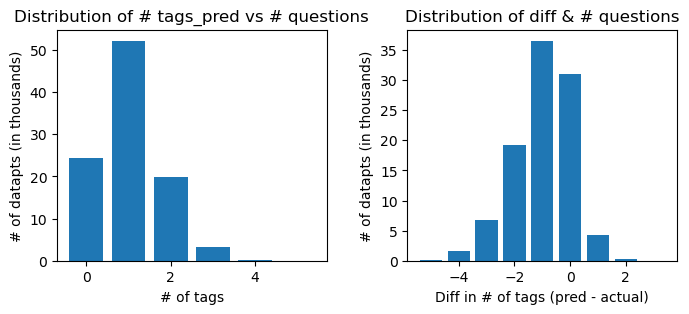

In [10]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_train = lin_svm_clf1.predict(train_x)

# Generate performance report
analyse_prediction(train_y, y_pred_train, 10, vocab, "Lin-SVM (OVR): Train data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


--------- Lin-SVM (OVR): Test data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 1, 0.0%
1b. Number & percent of datapoints having 0 predicted tags: 6420, 25.68%


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          93.7%     71.3%     46.4%     56.2%   
java        95.9%     83.7%     58.8%     69.1%   
php         96.9%     85.1%     69.2%     76.3%   
javascript  95.7%     84.9%     47.7%     61.1%   
android     98.8%     96.0%     83.7%     89.5%   
jquery      97.7%     90.0%     70.1%     78.8%   
c++         97.6%     80.9%     47.7%     60.0%   
python      98.7%     91.3%     69.7%     79.1%   
iphone      97.5%     71.6%     40.8%     52.0%   
html        96.9%     67.1%     12.9%     21.7%   

Micro-avg   22.4%     80.3%     40.8%     54.1%   
Macro-avg   22.4%     49.9%     29.2%     34.2%   


Block execution time:  0:03:12.501963


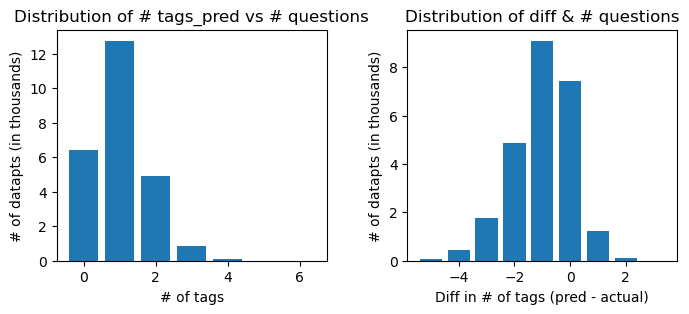

In [11]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_test = lin_svm_clf1.predict(test_x)

# Generate performance report
analyse_prediction(test_y, y_pred_test, 10, vocab, "Lin-SVM (OVR): Test data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

<p style='font-size:18px'><b> Grid Search CV </b></p>

In [12]:
def grid_search_cv(hyper_params, train_x, train_y, cv_x, cv_y):
    
    # Creating the mesh grid of hyperparameters as a pandas dataframe
    hyper_param_grid = pd.DataFrame()
    alpha_vals = hyper_params['alpha']
    penalty_vals = hyper_params['penalty']
    temp = []
    
    for alpha_val in alpha_vals:
        for penalty_val in penalty_vals:
            temp.append((alpha_val, penalty_val))
            
    hyper_param_grid['alpha'] = [x for (x, y) in temp]
    hyper_param_grid['penalty'] = [y for (x, y) in temp]
    hyper_param_grid['train_score'] = np.zeros(len(temp))
    hyper_param_grid['cv_score'] = np.zeros(len(temp))
    
    
    # Iterating over the mesh grid and training models for each hyper parameter combination
    best_cv_score = 0
    best_estimator = 0
    best_params = {'alpha': 0, 'penalty': 0}
    
    start_ = datetime.datetime.now()
    for i in range(hyper_param_grid.shape[0]):
        
        alpha_val = hyper_param_grid.alpha.iloc[i]
        penalty_val = hyper_param_grid.penalty.iloc[i]
        
        # Model training
        linsvm = OneVsRestClassifier(SGDClassifier(alpha = alpha_val, penalty = penalty_val, loss='hinge', max_iter=2000))
        linsvm.fit(train_x, train_y)
        
        # Model prediction on train data
        y_pred_train = linsvm.predict(train_x)
        train_scr = f1_score(train_y, y_pred_train, average = 'micro')
        hyper_param_grid.train_score.iloc[i] = train_scr
        
        # Model prediction on CV data
        y_pred_cv = linsvm.predict(cv_x)
        cv_scr = f1_score(cv_y, y_pred_cv, average = 'micro')
        hyper_param_grid.cv_score.iloc[i] = cv_scr
        
        # Save this model if it is the best estimator so far
        if cv_scr > best_cv_score:
            best_cv_score = cv_scr
            best_estimator = linsvm # is .copy necessary here?
            best_params = {'alpha': alpha_val, 'penalty': penalty_val}
        
        # Verbose the progress & time taken for latest iteration
        end_ = datetime.datetime.now() - start_
        print("Completed iteration: {}/{} | Time taken: {}".format(i+1, hyper_param_grid.shape[0]+1, end_))
        start_ = datetime.datetime.now()
            
    return {'hyper_param_scores': hyper_param_grid, 'best_estimator': best_estimator, 'best_params': best_params}    
    

<p style='font-size:16px'><b> Grid Search CV trial 1 </b></p>


In [13]:
start_time = datetime.datetime.now()

# Defining the hyper parameter value to be experimented with
hyper_params2 = {'alpha': [10**-6, 10**-4, 10**-2, 10**0, 10**2], 'penalty': ['l2', 'l1', 'elasticnet']}
linsvm_gcv2 = grid_search_cv(hyper_params2, train_x, train_y, cv_x, cv_y)

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 1/16 | Time taken: 0:42:12.643175


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 2/16 | Time taken: 0:56:12.085935


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 3/16 | Time taken: 1:02:08.065924


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 4/16 | Time taken: 0:41:00.405591


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 5/16 | Time taken: 0:45:28.666509


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 6/16 | Time taken: 0:45:41.284807


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 7/16 | Time taken: 0:41:23.047773


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 8/16 | Time taken: 0:46:58.757679


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 9/16 | Time taken: 0:47:24.467689


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 10/16 | Time taken: 0:51:38.025887


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 11/16 | Time taken: 1:12:27.905262


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 12/16 | Time taken: 1:11:46.916984


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 13/16 | Time taken: 0:42:21.213041


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 14/16 | Time taken: 0:49:26.641568


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 15/16 | Time taken: 0:49:26.750333

Block execution time:  12:45:37.951815


In [14]:
print(linsvm_gcv2['best_params'])
linsvm_gcv2['hyper_param_scores']

{'alpha': 1e-06, 'penalty': 'elasticnet'}


,alpha,penalty,train_score,cv_score
0,0.000001,l2,0.997103,0.546970
1,0.000001,l1,0.994525,0.547160
2,0.000001,elasticnet,0.996524,0.553062
3,0.000100,l2,0.413836,0.389764
4,0.000100,l1,0.425538,0.426076
5,0.000100,elasticnet,0.363189,0.364384
6,0.010000,l2,0.000000,0.000000
7,0.010000,l1,0.000000,0.000000
8,0.010000,elasticnet,0.000000,0.000000
9,1.000000,l2,0.000000,0.000000


In [15]:
# Following two functions are defined to plot & visualise the results of grid search function

def sci_notation(alpha_vals):
    
    sci_num = []
    
    for num in alpha_vals:
        
        pow_10 = int(math.log(num, 10))
        
        if pow_10 > 1:
            quotient_10 = round(num/(10**pow_10), 2)
            sci_num.append(str(quotient_10) + 'e' + str(pow_10))
        elif pow_10 < 0:
            pow_10 = pow_10 - 1
            quotient_10 = round(num/(10**pow_10), 2)
            sci_num.append(str(quotient_10) + 'e' + str(pow_10))
        else:
            quotient_10 = round(num, 2)
            sci_num.append(str(quotient_10))
    
    return sci_num

            
            
def plot_gcv(alpha_vals, train_scores, cv_scores, axs, plot_labels):
    
    # Plot the graph of hyperparam vs train & CV F1-score
    x = np.arange(len(alpha_vals))
    axs.plot(x, train_scores, color = 'b', label = 'Train score')
    axs.plot(x, cv_scores, color = 'r', label = 'CV score')
    axs.xaxis.set_ticks(x)
    alpha_vals = sci_notation(alpha_vals)
    axs.xaxis.set_ticklabels(alpha_vals)
    axs.legend()
    axs.set_ylim([0, 1.5])
    
    # Name the x, y axis & set the title
    (xlab, ylab, title) = plot_labels    
    axs.set(xlabel = xlab, ylabel = ylab, title = title) 

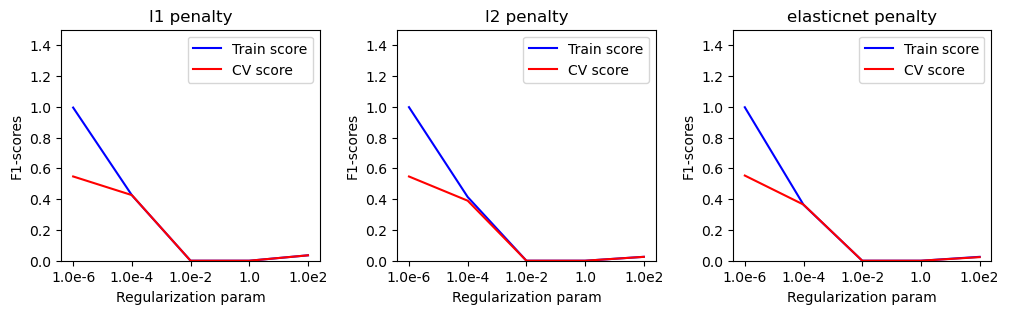

In [40]:
# Visualising the GCV
fig1 = plt.figure(figsize = (12,3))
fig1.subplots_adjust(wspace = 0.3)
axs = fig1.subplots(1,3)

hp_grid = linsvm_gcv2['hyper_param_scores']

penalty_vals = ['l1', 'l2', 'elasticnet']

for i in range(len(penalty_vals)):
    item = penalty_vals[i]
    alpha_vals = hp_grid.alpha[(hp_grid.penalty == item)]
    train_scores = hp_grid.train_score[(hp_grid.penalty == item)]
    cv_scores = hp_grid.cv_score[(hp_grid.penalty == item)]    
    plot_labels = ('Regularization param', 'F1-scores', item + ' penalty')
    plot_gcv(alpha_vals, train_scores, cv_scores, axs[i], plot_labels)

In [17]:
start_time = datetime.datetime.now()

# Using the best estimator decided by above Grid search
lin_svm_clf2 = linsvm_gcv2['best_estimator']

print("Block execution time: ", datetime.datetime.now() - start_time)

Block execution time:  0:00:00



--------- Lin-SVM (OVR): Train data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 7, 0.01%
1b. Number & percent of datapoints having 0 predicted tags: 140, 0.14%


2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          100.0%    99.9%     99.9%     99.9%   
java        100.0%    99.9%     100.0%    99.9%   
php         100.0%    99.8%     100.0%    99.9%   
javascript  100.0%    100.0%    99.9%     100.0%  
android     100.0%    99.9%     100.0%    100.0%  
jquery      100.0%    99.5%     100.0%    99.8%   
c++         99.9%     99.9%     97.9%     98.9%   
python      100.0%    99.9%     100.0%    100.0%  
mysql       100.0%    100.0%    100.0%    100.0%  
iphone      100.0%    99.9%     99.9%     99.9%   

Micro-avg   98.6%     99.8%     99.5%     99.7%   
Macro-avg   98.6%     99.7%     99.4%     99.5%   


Block execution time:  0:17:11.873911


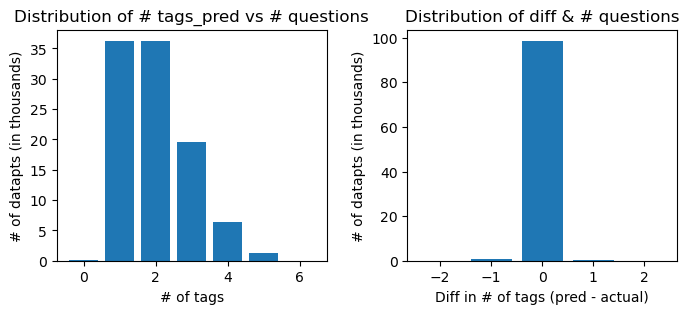

In [18]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_train = lin_svm_clf2.predict(train_x)

# Generate performance report
analyse_prediction(train_y, y_pred_train, 10, vocab, "Lin-SVM (OVR): Train data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


--------- Lin-SVM (OVR): CV data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 9, 0.04%
1b. Number & percent of datapoints having 0 predicted tags: 4364, 17.46%


2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          92.9%     62.0%     52.2%     56.7%   
java        95.3%     76.0%     58.7%     66.2%   
php         96.3%     79.5%     68.5%     73.6%   
javascript  95.1%     70.0%     51.0%     59.0%   
android     98.8%     96.1%     84.6%     90.0%   
jquery      97.5%     76.5%     80.4%     78.4%   
c++         97.7%     75.2%     52.2%     61.6%   
python      98.7%     88.9%     70.6%     78.7%   
iphone      97.4%     65.5%     53.4%     58.9%   
asp.net     97.9%     76.4%     52.1%     61.9%   

Micro-avg   20.9%     68.4%     46.4%     55.3%   
Macro-avg   20.9%     58.2%     36.1%     42.7%   


Block execution time:  0:03:10.128596


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


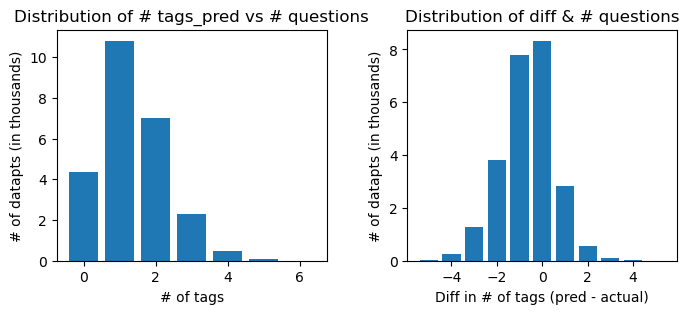

In [19]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_cv = lin_svm_clf2.predict(cv_x)

# Generate performance report
analyse_prediction(cv_y, y_pred_cv, 10, vocab, "Lin-SVM (OVR): CV data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


--------- Lin-SVM (OVR): Test data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 8, 0.03%
1b. Number & percent of datapoints having 0 predicted tags: 4512, 18.05%


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          93.0%     61.6%     51.3%     56.0%   
java        95.4%     75.6%     60.1%     66.9%   
php         96.4%     77.9%     70.2%     73.9%   
javascript  95.3%     72.9%     52.9%     61.3%   
android     98.7%     97.0%     81.9%     88.8%   
jquery      97.3%     77.0%     78.8%     77.9%   
c++         97.4%     75.1%     49.8%     59.9%   
python      98.6%     90.6%     68.3%     77.9%   
iphone      97.2%     60.2%     51.4%     55.4%   
html        96.5%     46.4%     42.0%     44.0%   

Micro-avg   20.9%     68.9%     46.2%     55.3%   
Macro-avg   20.9%     59.0%     35.6%     42.3%   


Block execution time:  0:03:12.058210


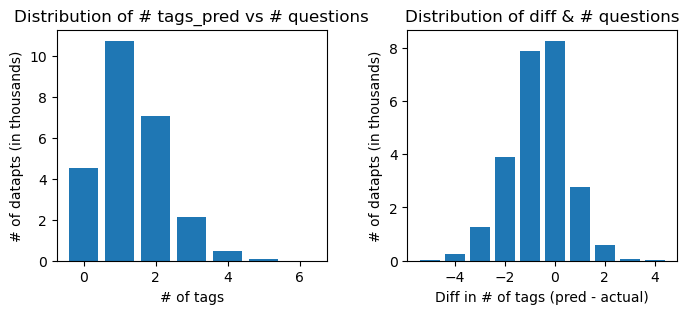

In [20]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_test = lin_svm_clf2.predict(test_x)

# Generate performance report
analyse_prediction(test_y, y_pred_test, 10, vocab, "Lin-SVM (OVR): Test data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

<p style='font-size:16px'><b> Grid Search CV trial 2 </b></p>


In [42]:
start_time = datetime.datetime.now()

# GridSearchCV for hyperparameter tuning of regularization paramter

# Defining the hyper parameter value to be experimented with
alpha_vals = []
start_val = 10**-8
for i in range(4):
    alpha_vals = alpha_vals + list(np.linspace(start_val, start_val*10, 4, endpoint = False))
    start_val *= 10

hyper_params3 = {'alpha': alpha_vals, 'penalty': ['l1']}
linsvm_gcv3 = grid_search_cv(hyper_params3, train_x, train_y, cv_x, cv_y)

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 1/17 | Time taken: 1:11:05.906671


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 2/17 | Time taken: 1:09:34.385449


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 3/17 | Time taken: 1:17:45.038196


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 4/17 | Time taken: 1:08:34.953990


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 5/17 | Time taken: 1:05:41.410399


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 6/17 | Time taken: 1:01:20.151944


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 7/17 | Time taken: 0:58:24.905076


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 8/17 | Time taken: 0:56:40.675865


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 9/17 | Time taken: 0:55:24.559851


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 10/17 | Time taken: 0:49:27.861773


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 11/17 | Time taken: 0:47:51.943028


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 12/17 | Time taken: 0:47:12.428701


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 13/17 | Time taken: 0:46:43.732372


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 14/17 | Time taken: 0:45:43.016889


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 15/17 | Time taken: 0:45:21.466441


C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hyper_param_grid.train_score.iloc[i] = train_scr
C:\Users\Tejas Chavan\AppData\Local\Temp\ipykernel_4264\1096226136.py:37

Completed iteration: 16/17 | Time taken: 0:44:59.374680

Block execution time:  15:11:52.912471


In [43]:
print(linsvm_gcv3['best_params'])
linsvm_gcv3['hyper_param_scores']

{'alpha': 3.2499999999999994e-06, 'penalty': 'l1'}


,alpha,penalty,train_score,cv_score
0,1.000000e-08,l1,0.999733,0.545825
1,3.250000e-08,l1,0.999741,0.547845
2,5.500000e-08,l1,0.999621,0.546515
3,7.750000e-08,l1,0.999678,0.549161
4,1.000000e-07,l1,0.999514,0.549220
5,3.250000e-07,l1,0.999057,0.545961
6,5.500000e-07,l1,0.998587,0.548231
7,7.750000e-07,l1,0.996912,0.547379
8,1.000000e-06,l1,0.993353,0.546886
9,3.250000e-06,l1,0.799448,0.571100


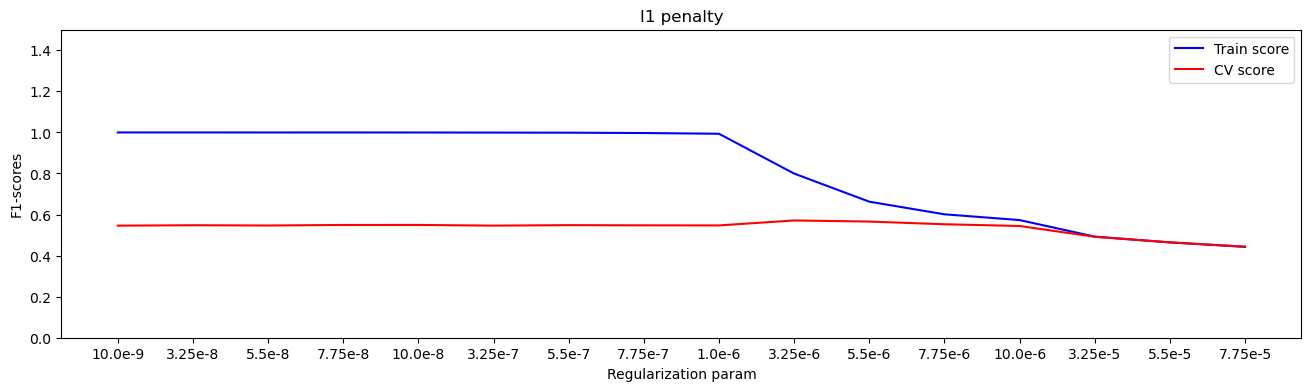

In [44]:
# Visualising the GCV
fig2 = plt.figure(figsize = (16,4))
fig2.subplots_adjust(wspace = 0.3)
axs = fig2.subplots(1)

hp_grid = linsvm_gcv3['hyper_param_scores']

alpha_vals = hp_grid.alpha
train_scores = hp_grid.train_score
cv_scores = hp_grid.cv_score    
plot_labels = ('Regularization param', 'F1-scores', 'l1 penalty')
plot_gcv(alpha_vals, train_scores, cv_scores, axs, plot_labels)

In [45]:
start_time = datetime.datetime.now()

# Using the best estimator decided by above Grid search
lin_svm_clf3 = linsvm_gcv3['best_estimator']

print("Block execution time: ", datetime.datetime.now() - start_time)

Block execution time:  0:00:00



--------- Lin-SVM (OVR): Train data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 2, 0.0%
1b. Number & percent of datapoints having 0 predicted tags: 7656, 7.66%


2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          97.8%     91.9%     82.9%     87.2%   
java        98.4%     94.0%     85.0%     89.3%   
php         98.7%     95.1%     86.7%     90.7%   
javascript  98.4%     93.9%     82.1%     87.6%   
android     99.6%     97.7%     95.4%     96.5%   
jquery      99.0%     95.2%     86.9%     90.9%   
c++         99.2%     94.0%     84.7%     89.1%   
python      99.5%     96.0%     90.4%     93.1%   
mysql       99.4%     95.7%     85.3%     90.2%   
iphone      99.1%     90.5%     81.9%     86.0%   

Micro-avg   50.0%     92.4%     70.5%     79.9%   
Macro-avg   50.0%     91.7%     59.4%     69.1%   


Block execution time:  0:17:04.056521


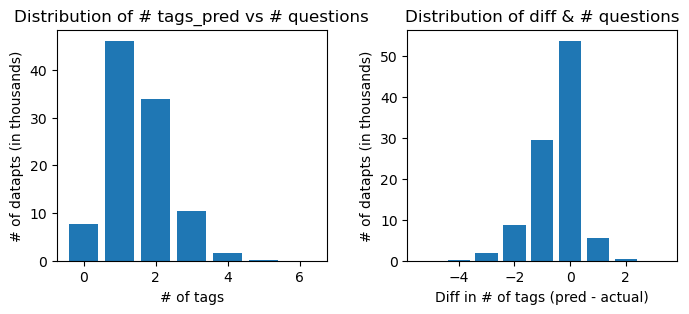

In [46]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_train = lin_svm_clf3.predict(train_x)

# Generate performance report
analyse_prediction(train_y, y_pred_train, 10, vocab, "Lin-SVM (OVR): Train data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


--------- Lin-SVM (OVR): CV data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 2, 0.01%
1b. Number & percent of datapoints having 0 predicted tags: 3948, 15.79%


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          93.2%     63.6%     54.3%     58.6%   
java        95.5%     76.6%     62.0%     68.6%   
php         96.7%     85.3%     68.9%     76.2%   
javascript  95.3%     70.7%     55.1%     61.9%   
android     98.9%     93.9%     88.3%     91.0%   
jquery      97.8%     85.5%     74.4%     79.6%   
c++         97.7%     69.9%     59.8%     64.5%   
python      98.8%     86.7%     76.6%     81.4%   
iphone      97.5%     66.4%     53.4%     59.2%   
asp.net     98.0%     77.3%     59.0%     66.9%   

Micro-avg   22.6%     71.3%     47.6%     57.1%   
Macro-avg   22.6%     56.9%     37.0%     42.4%   


Block execution time:  0:03:09.500408


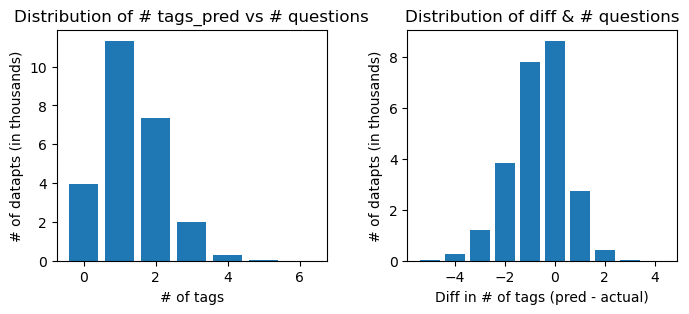

In [47]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_cv = lin_svm_clf3.predict(cv_x)

# Generate performance report
analyse_prediction(cv_y, y_pred_cv, 10, vocab, "Lin-SVM (OVR): CV data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


--------- Lin-SVM (OVR): Test data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 1, 0.0%
1b. Number & percent of datapoints having 0 predicted tags: 4008, 16.03%


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          93.1%     62.1%     53.8%     57.7%   
java        95.6%     76.1%     64.2%     69.7%   
php         96.8%     83.8%     70.1%     76.3%   
javascript  95.4%     72.8%     55.2%     62.8%   
android     98.9%     94.1%     86.9%     90.3%   
jquery      97.7%     87.8%     72.0%     79.1%   
c++         97.5%     69.6%     59.6%     64.2%   
python      98.7%     87.4%     75.4%     81.0%   
iphone      97.3%     61.9%     52.0%     56.5%   
html        96.8%     52.7%     27.7%     36.3%   

Micro-avg   22.6%     71.6%     47.5%     57.1%   
Macro-avg   22.6%     57.0%     36.5%     42.1%   


Block execution time:  0:03:13.168094


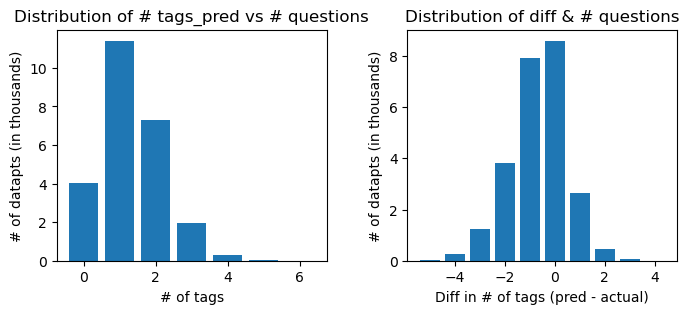

In [48]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_test = lin_svm_clf3.predict(test_x)

# Generate performance report
analyse_prediction(test_y, y_pred_test, 10, vocab, "Lin-SVM (OVR): Test data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

In [56]:
joblib.dump(lin_svm_clf1, 'models/lin_svm_clf1.pkl')
joblib.dump(linsvm_gcv2, 'models/linsvm_gcv2.pkl')
joblib.dump(linsvm_gcv3, 'models/linsvm_gcv3.pkl')

['E:/ai_projects/data_storage/Stack over flow tagging 5/models/linsvm_gcv3.pkl']